# **KNN datas**

Import the required libraries and modules in：

Personal_KNN_recommender

In [1]:
!pip install scikit-surprise

import pandas as pd
import numpy as np
import os
from surprise import Reader, Dataset, SVD
from surprise.model_selection import cross_validate
from surprise import KNNBaseline
from surprise import KNNWithMeans
from surprise import KNNBasic
import csv

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 772.0/772.0 kB 11.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.3-cp310-cp310-linux_x86_64.whl size=3095464 sha256=421699bdd0d9387c3ac86f675ec9a4fe1317ca8ef543254e8de9ed46f4219603
  Stored in directory: /root/.cache/pip/wheels/a5/ca/a8/4e28def53797fdc4363ca4af740db15a9c2f1595ebc51fb445
Successfully built scikit-surprise


执行代码

修改路径，关联数据集

In [10]:
class Personal_KNN_recommender:
    def __init__(self, mode=0):
        self.index = pd.read_csv('/content/movies.csv')
        self.poster_urls = pd.read_csv('/content/Poster.csv').set_index('movieId')['Poster'].to_dict()
        self.reader = Reader()
        self.ratings = pd.read_csv('/content/train.csv')
        self.testings = pd.read_csv('/content/test.csv')
        data = Dataset.load_from_df(self.ratings[['userId', 'movieId', 'rating']], self.reader)
        trainset = data.build_full_trainset()
        sim_options = {'name': 'pearson_baseline', 'user_based': True}
        if mode == 0:
            self.algo = KNNBaseline(sim_options=sim_options)
        elif mode == 1:
            self.algo = KNNWithMeans(sim_options=sim_options)
        elif mode == 2:
            self.algo = KNNBasic(sim_options=sim_options)
        else:
            exit(0)
        self.userid = []
        for i in range(len(self.testings['userId'])):
            if not self.testings['userId'][i] in self.userid:
                self.userid.append(self.testings['userId'][i])
        self.algo.fit(trainset)



    def get_similar_users(self, usrID, num=10):
        user_inner_id = self.algo.trainset.to_inner_uid(usrID)
        user_neighbors = self.algo.get_neighbors(user_inner_id, k=num)
        user_neighbors = [self.algo.trainset.to_raw_uid(inner_id) for inner_id in user_neighbors]
        return user_neighbors


    def recommend(self, usrID, num=5):
        existed_movie = list(self.ratings[self.ratings.userId == usrID]['movieId'])
        similar_users = self.get_similar_users(usrID, num)
        movies_dict = {}
        for i in similar_users:
            movie = list(self.ratings[self.ratings.userId == i]['movieId'])
            vote = list(self.ratings[self.ratings.userId == i]['rating'])
            for j in range(len(vote)):
                if not (movie[j] in existed_movie):
                    if movie[j] in movies_dict.keys():
                        movies_dict[movie[j]] += vote[j]
                    else:
                        movies_dict[movie[j]] = vote[j]
        result = sorted(movies_dict.items(), key=lambda x: x[1], reverse=True)
        result = result[:num]

        recommending = []
        poster_urls = []
        for i in result:
            movie_id = i[0]
            recommending.append(self.index[self.index.movieId == movie_id]['title'].values[0])
            poster_url = self.poster_urls.get(movie_id)
            if poster_url:
                try:
                    response = urllib.request.urlopen(poster_url)
                    poster_urls.append(poster_url)
                except urllib.error.HTTPError:
                    continue  # Skip invalid poster URLs
            else:
                continue  # Skip invalid poster URLs

        return recommending, poster_urls


Import the required libraries and modules to show：

Poster URL

In [13]:
! pip install requests pillow
import urllib.request
from PIL import Image
from IPython.display import Image as DisplayImage
from IPython.display import Image, display
# Display images directly in the code.
import requests
from PIL import Image
from io import BytesIO

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Import the required libraries and modules in：

Color Bars

In [4]:
!pip install matplotlib
import argparse
import cv2
from PIL import Image
import io
import matplotlib.pyplot as plt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# **Color Bars**

Based on the original basis to increase the title part and resize, the image introduction format from jpg to url

In [14]:
def generate_color_bar(img_url, clusters, movie_title):
    response = urllib.request.urlopen(img_url)
    img = np.array(Image.open(BytesIO(response.read())))
    clustered, label, center = kmeans_color_quant(img, clusters)
    hist = get_histogram(label)
    bar = draw_color_bar(hist, center)

    fig, ax = plt.subplots(1, 2, figsize=(10, 6))
    ax[0].imshow(clustered)
    ax[0].axis('off')
    ax[0].set_title('Quantized Image')

    ax[1].imshow(bar)
    ax[1].axis('off')
    ax[1].set_title('Color Bar')

    # Add a movie title
    fig.suptitle(movie_title, fontsize=16, fontweight='bold')

    plt.show()

def kmeans_color_quant(img, k):
    # Reshape to pixel list
    Z = np.float32(img.reshape((-1, 3)))

    # Define criteria and perform clustering
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
    _, label, center = cv2.kmeans(Z, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

    # Convert back to uint8 and reshape to the original image
    center = np.uint8(center)
    clustered = center[label.flatten()].reshape(img.shape)

    return clustered, label, center

def get_histogram(label):
    n_labels = np.arange(0, len(np.unique(label)) + 1)
    hist, _ = np.histogram(label, bins=n_labels, density=True)
    return hist

def draw_color_bar(hist, center):
    # Initialize a 150x600 pixel color bar
    bar = np.zeros((600, 150, 3), dtype='uint8')
    start = 0

    # Iterate through each percentage and color in zip(hist, center)
    for percentage, color in zip(hist, center):
        end = start + (percentage * 600)
        cv2.rectangle(bar, (0, int(start)), (150, int(end)), color.astype('uint8').tolist(), -1)
        start = end

    return bar

# **Input & Output**

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Please enter your user ID：1
Movie： Forrest Gump (1994)


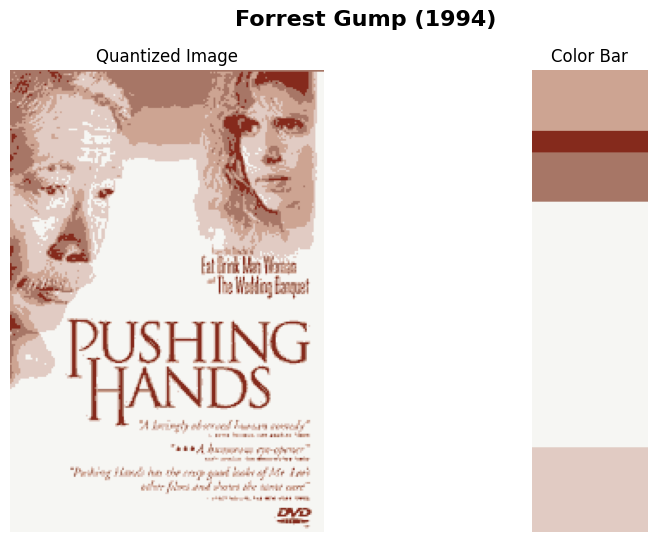


Movie： Pulp Fiction (1994)


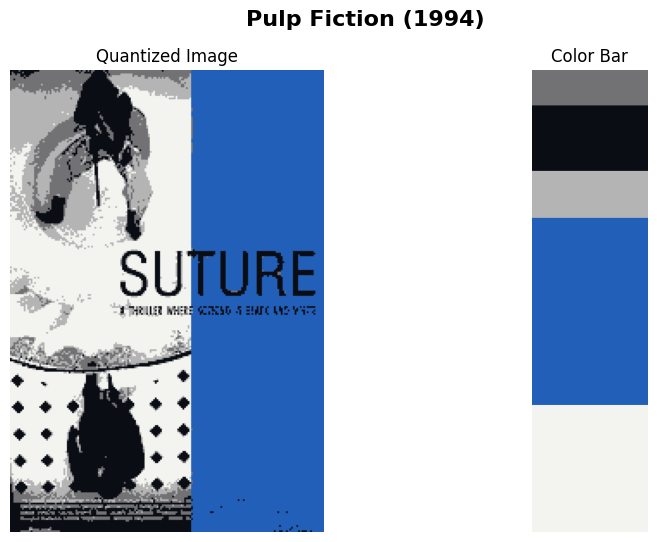


Movie： Shawshank Redemption, The (1994)


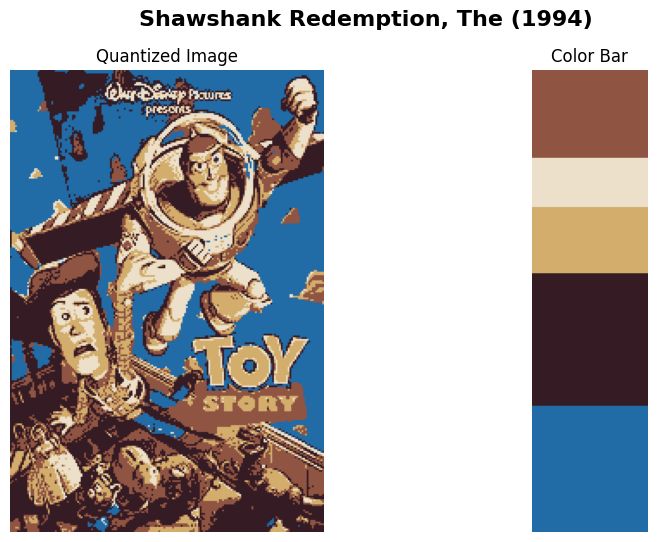


Movie： Toy Story (1995)


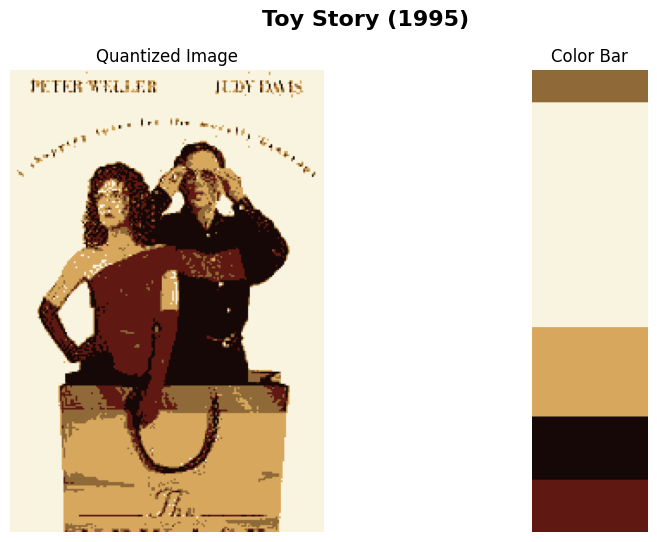


Movie： Mrs. Doubtfire (1993)


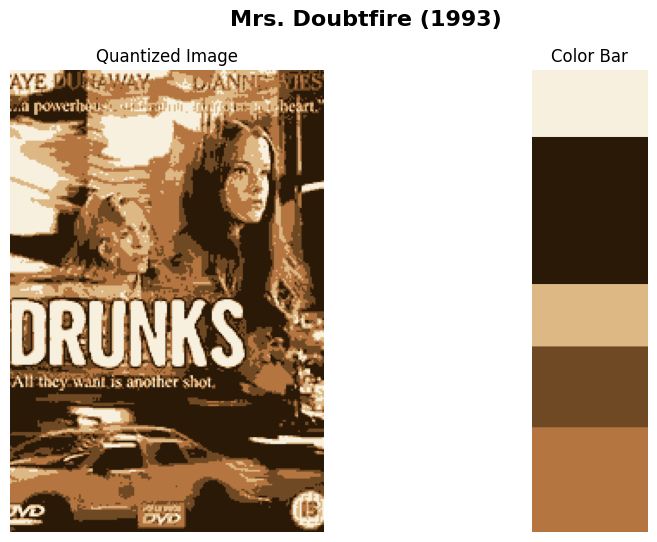


Movie： E.T. the Extra-Terrestrial (1982)


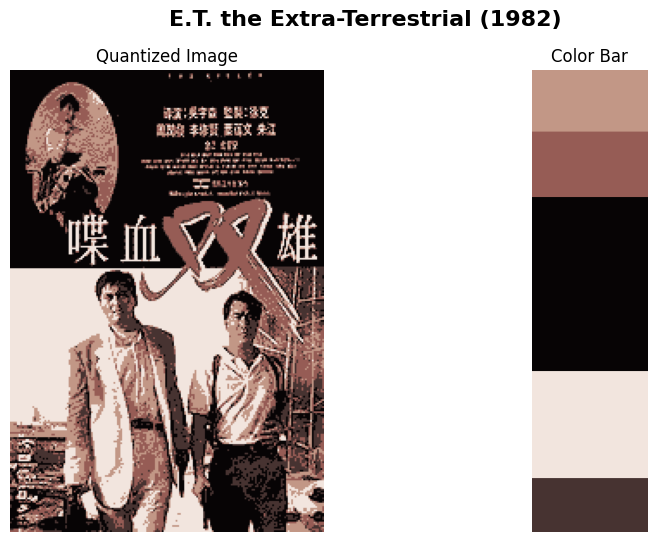


Movie： Departed, The (2006)


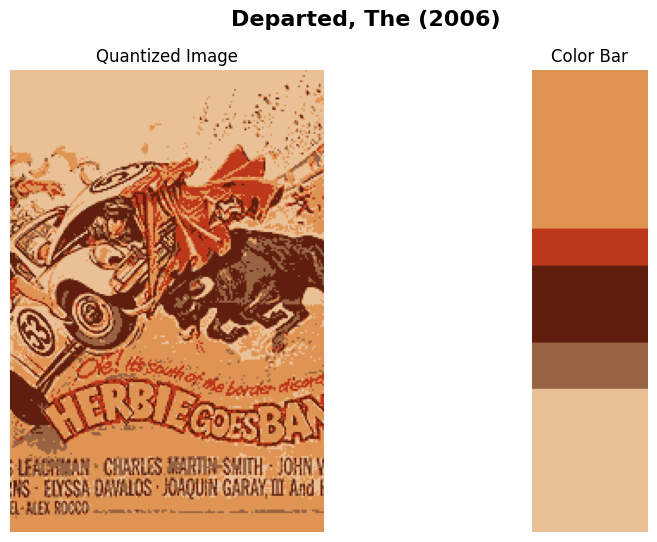


Movie： One Flew Over the Cuckoo's Nest (1975)


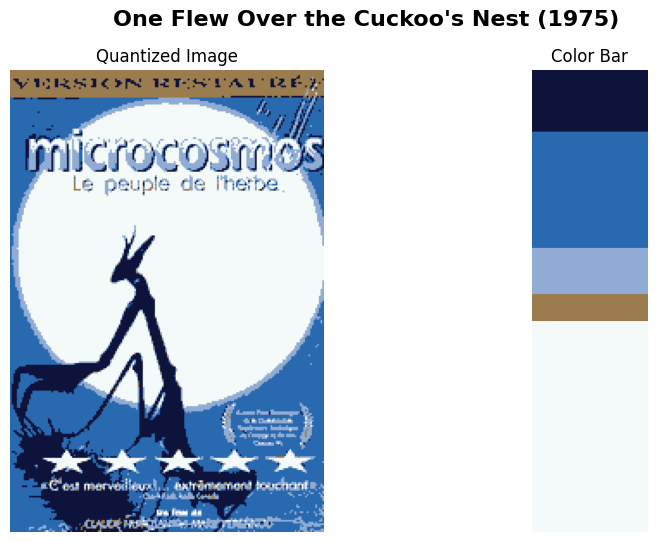


Movie： Breakfast Club, The (1985)

Movie： Reservoir Dogs (1992)



In [17]:
recommender = Personal_KNN_recommender()

# Get recommended movies
user_id = int(input("Please enter your user ID："))
recommended_movies, recommended_poster_urls = recommender.recommend(user_id, 10)

# Call the Code Color Bars function to generate a color bar
clusters = 5
for i in range(len(recommended_movies)):
    print("Movie：", recommended_movies[i])
    if i < len(recommended_poster_urls) and recommended_poster_urls[i]:
        generate_color_bar(recommended_poster_urls[i], clusters, recommended_movies[i])
    print()